<a href="https://colab.research.google.com/github/sdbrgo/Glossi/blob/main/glossi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Glossi, My Hair Care Buddy**




1. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

2. Import Dataset

In [2]:
data = "https://raw.githubusercontent.com/sdbrgo/Glossi/main/glossi-dataset-v1.csv" #insert name/link of the dataset
df = pd.read_csv(data)
#df.head()

3. Preprocess Data

*   **Encode** nominal values.
*   Assign X and y features

In [3]:
le = LabelEncoder()
#encode the nominal features
df['shampoo_used_today'] = le.fit_transform(df['shampoo_used_today'])
df['conditioner_used_today'] = le.fit_transform(df['conditioner_used_today'])

# Create placeholder columns for the next 3 days' dryness and heaviness metrics
target_cols = []
for day in range(1,4): #values for next 3 days
  for metric in ['min_dryness','max_dryness','min_heaviness','max_heaviness']:
    new_col_name = f"{metric}_day{day}"
    df[new_col_name] = 0.0 # Initialize with a placeholder value (e.g., 0.0)
    target_cols.append(new_col_name)
    for day in range(1, 4):
        df[f'{metric}_day{day}'] = df[metric].shift(-day)

#drop the rows with missing values
df = df.dropna(subset=[f'{m}_day{d}' for m in ['min_dryness','max_dryness','min_heaviness','max_heaviness'] for d in range(1,4)])

#assign X and y features
X = df[['shampoo_used_today','conditioner_used_today','leave_in_amt','sweat','humidity','bath_intensity','wind_exposure']]
y = df[target_cols]

4. Train Model

* Use 70-15-15 Train-Validation-Test split   
* Use linear regression



In [4]:
#first split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

#second split: validation (15%) and test (15%) from the 30%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#print values
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

#train model
lr = LinearRegression()
lr.fit(X_train, y_train)

Training set size: 76
Validation set size: 16
Test set size: 17


LinearRegression()

4.1 Predict on Validation Set

*   Fine-tune if necessary.



In [5]:
#predict on validation set
y_val_pred = lr.predict(X_val)

#evaluate performance
from sklearn.metrics import mean_squared_error, r2_score

r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation R²: {r2_val:.3f}")
print(f"Validation RMSE: {rmse_val:.3f}")

Validation R²: -0.039
Validation RMSE: 1.031


In [6]:
#since the metric results are unsatisfactory,
#let's try FEATURE SCALING with linear regression
from sklearn.preprocessing import StandardScaler

#scale everything
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#retrain model using scaled data
lr.fit(X_train_scaled, y_train)
y_val_pred = lr.predict(X_val_scaled)

r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation R²: {r2_val:.3f}")
print(f"Validation RMSE: {rmse_val:.3f}")

Validation R²: -0.039
Validation RMSE: 1.031


In [7]:
#let's try RANDOM FOREST without feature scaling
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

#predict on validation set
y_val_pred = rf.predict(X_val)

r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation R²: {r2_val:.3f}")
print(f"Validation RMSE: {rmse_val:.3f}")

Validation R²: -0.140
Validation RMSE: 1.066


In [8]:
#let's try RANDOM FOREST and FEATURE SCALING

#retrain model using random forest & scaled data
rf.fit(X_train_scaled, y_train)
y_val_pred = rf.predict(X_val_scaled)

r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Validation R²: {r2_val:.3f}")
print(f"Validation RMSE: {rmse_val:.3f}")

Validation R²: -0.114
Validation RMSE: 1.054


**4.2 Results and Observation**

---

*   The Linear Regression, Random Forest, and Feature Scaling failed to respect the nature of the data. A model that is more time-aware is necessary. Thus, models like **XGBoost** and others will be explored.   



**5. Redo initial Setup**
1.   Import dataset as `new_df`
2.   Encode nominal values
3. Create **lag features**

In [9]:
#reimport dataset
new_df = pd.read_csv(data)

#encode the nominal features
new_df['shampoo_used_today'] = le.fit_transform(new_df['shampoo_used_today'])
new_df['conditioner_used_today'] = le.fit_transform(new_df['conditioner_used_today'])

#new_df.head()

In [10]:
#make LAG FEATURES for XGBoost
for lag in range(1, 8):
    for metric in ['min_dryness', 'max_dryness', 'min_heaviness', 'max_heaviness']:
        new_df[f'{metric}_lag{lag}'] = new_df[metric].shift(lag)

#drop rows with null ('NaN') values
new_df = new_df.dropna().reset_index(drop=True)

**6. Train XGBoost Regressor**

In [11]:
!pip install xgboost

In [76]:
from xgboost import XGBRegressor

#features and targets
base_features = [
    'shampoo_used_today','conditioner_used_today','leave_in_amt','sweat','humidity','bath_intensity','wind_exposure'
]
lag_features = [ #dynamically add lag features
    f'{metric}_lag{lag}'
    for lag in range(1, 8)
    for metric in ['min_dryness', 'max_dryness', 'min_heaviness', 'max_heaviness']
]
X = new_df[base_features + lag_features] #combine all features

y = new_df[['min_dryness','max_dryness','min_heaviness','max_heaviness']]

#first split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)

#second split: validation (15%) and test (15%) from the 30%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

#train
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.1,
    gamma=0.6,
    random_state=42
)
xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.6, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

**7. Validate**

*   If metric results are unsatisfactory, fine-tune hyperparameters.



In [77]:
# Validate
y_val_pred = xgb.predict(X_val)

r2 = r2_score(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation R²: {r2:.3f}, RMSE: {rmse:.3f}")

Validation R²: 0.102, RMSE: 0.835


**8. Visualize Actual vs. Predicted Curves (Validation)**

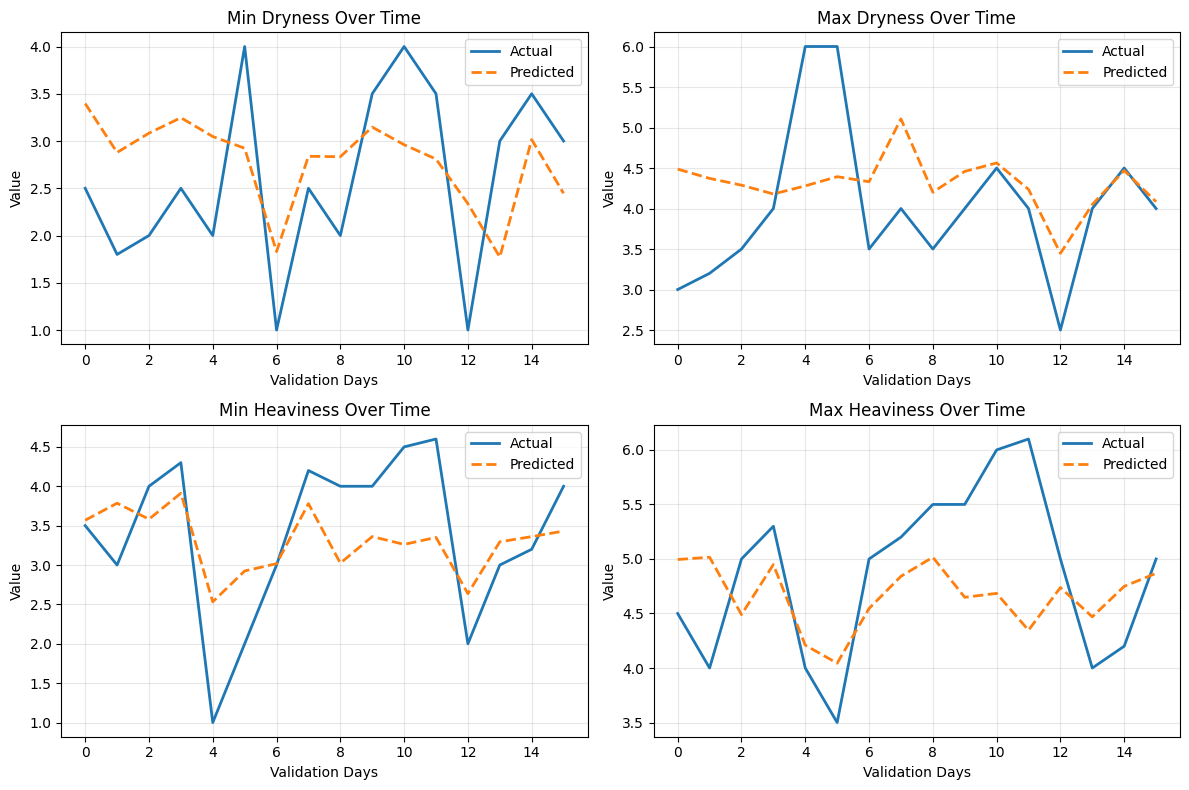

In [78]:
metrics = ['min_dryness', 'max_dryness', 'min_heaviness', 'max_heaviness']

# Create a figure for each metric
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(y_val[metric].values, label='Actual', linewidth=2)
    plt.plot(y_val_pred[:, i], label='Predicted', linestyle='--', linewidth=2)
    plt.title(f"{metric.replace('_', ' ').title()} Over Time")
    plt.xlabel("Validation Days")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()